In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from random import randint
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [67]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_Mutation/Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_Mutation_CNA/Predictions/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_CNA/Predictions/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_Mutation/Predictions/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_Mutation/Figures/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)

In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (EGFRi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (EGFRi)

GDSCE = pd.read_csv("GDSC_exprs.z.EGFRi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
683667,0.8924335646616343,-0.2118047645974752,-1.5249963829654445,-0.5512338119420259,-0.1375180480622428,-0.5276262991742051,-0.0305604198225781,0.5226216566753464,0.4877783097403741,0.2252883573642275,...,-0.0156845434045267,-0.1612071417519457,1.2033249282722671,2.7714836839186687,-0.3165072496327769,-0.8849200030571541,-0.5104734344593952,0.2984361940989172,-0.4349407065496763,0.4747633022523675
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC mutation dataset (EGFRi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (EGFRi)

GDSCM = pd.read_csv("GDSC_mutations.EGFRi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
683667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC response dataset (EGFRi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (EGFRi)

GDSCR = pd.read_csv("GDSC_response.EGFRi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1
683665,0,-1.50094791622811,CUDC-101,1,1,1
683665,1,-0.966773876200563,EKB-569,1,1,1


In [12]:
# print count of cell lines for each drug (EGFRi)

GDSCR["drug"].value_counts()

drug
EKB-569                770
Afatinib (rescreen)    757
CUDC-101               754
Afatinib               738
Gefitinib              734
Cetuximab              725
HG-5-88-01             422
Lapatinib              371
Erlotinib              362
Name: count, dtype: int64

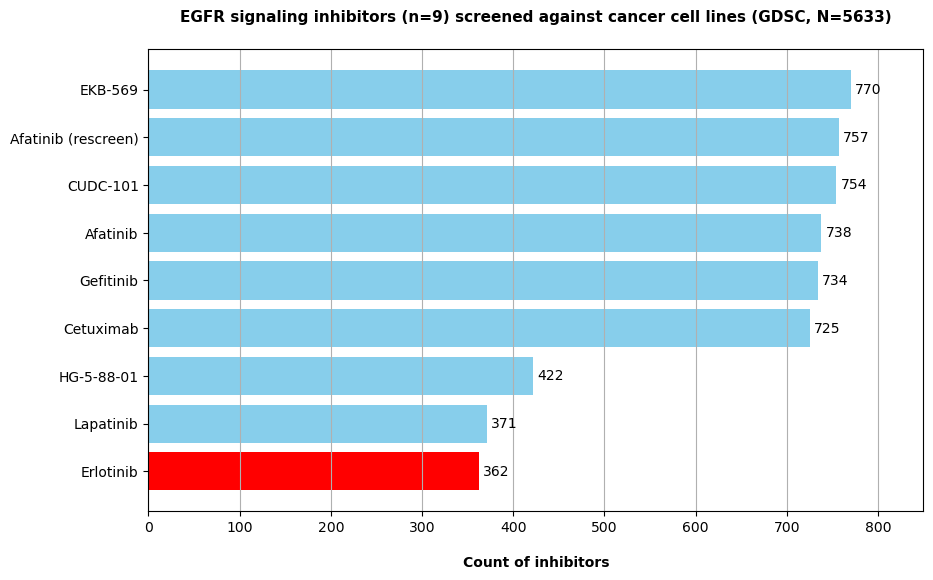

In [13]:
# plot EGFR signaling inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Erlotinib":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'EGFR signaling inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'EGFR Signaling Inhibitors with Their Counts (GDSC, Erlotinib).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX expression dataset homogenized with GDSC expression dataset (Erlotinib)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Erlotinib)

PDXEerlotinib = pd.read_csv("PDX_exprs.Erlotinib.eb_with.GDSC_exprs.Erlotinib.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEerlotinib = pd.DataFrame.transpose(PDXEerlotinib)
PDXEerlotinib.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1156,6.11861088229939,6.52864101100101,6.79951417489383,2.75014153880996,2.46025530503934,2.55715969202243,8.28052725761881,2.57788329077075,6.95887775544869,3.61452184934982,...,2.71395625069168,3.25738747236556,6.03809972147297,2.98821567577099,2.98369076792706,2.351997223295,2.52761397843368,5.09565670825996,4.1270944614262,2.42677851551937
X-1172,3.31280391584354,7.01865849503627,5.64214585248198,2.99828359748804,3.6752940409957,4.99060571336846,8.67761758763766,2.846798443615,9.99801881476899,3.81384234557669,...,2.76551893238154,3.3106737035931,4.94017287575563,2.98821567577099,2.98369076792706,2.351997223295,2.52761397843368,2.62204355997836,4.41769048689105,2.38094556877352
X-1323,5.21916353176773,3.70763705485075,6.05754416508987,2.75014153880996,3.00134646136568,2.46294977024261,7.39844941299792,3.10981562039544,10.013301293327,3.13578724141655,...,2.62947211484532,3.1747527931153,5.5262091243784,4.12076583575454,2.98369076792706,2.351997223295,2.52761397843368,2.62204355997836,4.02209193327285,2.27747617313197


In [16]:
# change directory to read PDX mutation dataset (Erlotinib)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [17]:
# read PDX mutation dataset (Erlotinib)

PDXMerlotinib = pd.read_csv("PDX_mutations.Erlotinib.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMerlotinib.drop_duplicates(keep='last')
PDXMerlotinib = pd.DataFrame.transpose(PDXMerlotinib)
PDXMerlotinib = PDXMerlotinib.loc[:, ~PDXMerlotinib.columns.duplicated()]

PDXMerlotinib.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1156,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,-0.05,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1172,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1323,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# variance threshold for GDSC expression dataset (EGFRi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [19]:
# fill NA values and binarize GDSC mutation dataset (EGFRi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [20]:
# select shared genes between GDSC and PDX expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEerlotinib.columns)
ls = ls.intersection(PDXMerlotinib.columns)

ls = pd.unique(ls)

print(f"GDSC and PDX # of common genes: {ls.shape[0]}")

GDSC and PDX # of common genes: 13861


In [21]:
# select shared samples between GDSC expression, mutation, and response datasets (EGFRi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 800


In [22]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

# There exists same sample names for different drugs, so row shape is different in GDSC response data

GDSC # of common samples and genes (Expression): (800, 13861)
GDSC # of common samples and genes (Mutation): (800, 13861)
GDSC # of samples (Response): 5633


In [23]:
# select shared samples between PDX expression and mutation datasets (Erlotinib) 

ls3 = PDXEerlotinib.index.intersection(PDXMerlotinib.index)

print(f"PDX # of common samples (Erlotinib): {ls3.shape[0]}")

PDX # of common samples (Erlotinib): 21


In [24]:
# select shared genes and samples between PDX expression and mutation datasets (Erlotinib)

PDXEerlotinib = PDXEerlotinib.loc[ls3, ls]
PDXMerlotinib = PDXMerlotinib.loc[ls3, ls]

print(f"PDX # of common samples and genes for Expression (Erlotinib): {PDXEerlotinib.shape}")
print(f"PDX # of common samples and genes for Mutation (Erlotinib): {PDXMerlotinib.shape}\n")

PDX # of common samples and genes for Expression (Erlotinib): (21, 13861)
PDX # of common samples and genes for Mutation (Erlotinib): (21, 13861)



In [25]:
# change directory to read DEGs (EGFRi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi


In [26]:
# read DEGs (EGFRi)

DEGs_filtered_data = pd.read_excel("EGFRi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors\n")

DEGs_filtered_data.head()

There are 1028 DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors



,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
4,CAV1,8


In [27]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id.shape[0]
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


1028

In [28]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [29]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1


In [34]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Afatinib',
 'Afatinib (rescreen)',
 'CUDC-101',
 'Cetuximab',
 'EKB-569',
 'Erlotinib',
 'Gefitinib',
 'HG-5-88-01',
 'Lapatinib'}

In [35]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([683665, 683665, 683665, 683665, 683665, 683665, 683665, 683665, 683665,
       683667,
       ...
       910930, 910941, 910941, 924248, 924248, 924248, 906849, 906849, 949162,
       949162],
      dtype='int64', length=5633)

In [36]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
dat.head()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,,,,,,,,,,,,,
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,0.336847206091621,Afatinib,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,3.15337617244149,Afatinib (rescreen),1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,5.88153515162963,Cetuximab,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,0.55852009402462,CUDC-101,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,0.599191006410089,EKB-569,1,1,1


In [37]:
# list count of cell lines as to tissues treated with erlotinib

filter = (dat["drug"] == "Erlotinib")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
leukemia             65
lymphoma             59
lung_SCLC            36
nervous_system       27
neuroblastoma        22
bone                 19
lung_NSCLC           18
skin                 18
large_intestine      15
urogenital_system    14
aero_dig_tract       13
digestive_system     12
breast               12
myeloma              11
kidney                8
soft_tissue           7
lung                  2
pancreas              2
thyroid               2
Name: count, dtype: int64

In [38]:
# list count of cell lines as to tissues treated with erlotinib

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    366
lung_small_cell_carcinoma    347
glioma                       341
melanoma                     311
breast                       299
Name: count, dtype: int64

In [39]:
# count of NSCLC samples

tissues = dat["GDSC\nTissue\ndescriptor 2"].value_counts()
count_selected_tissues = tissues["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues["lung_NSCLC_large cell"].astype(int) + \
                         tissues["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues["lung_NSCLC_not specified"].astype(int) + \
                         tissues["lung_NSCLC_carcinoid"].astype(int) 
count_selected_tissues

594

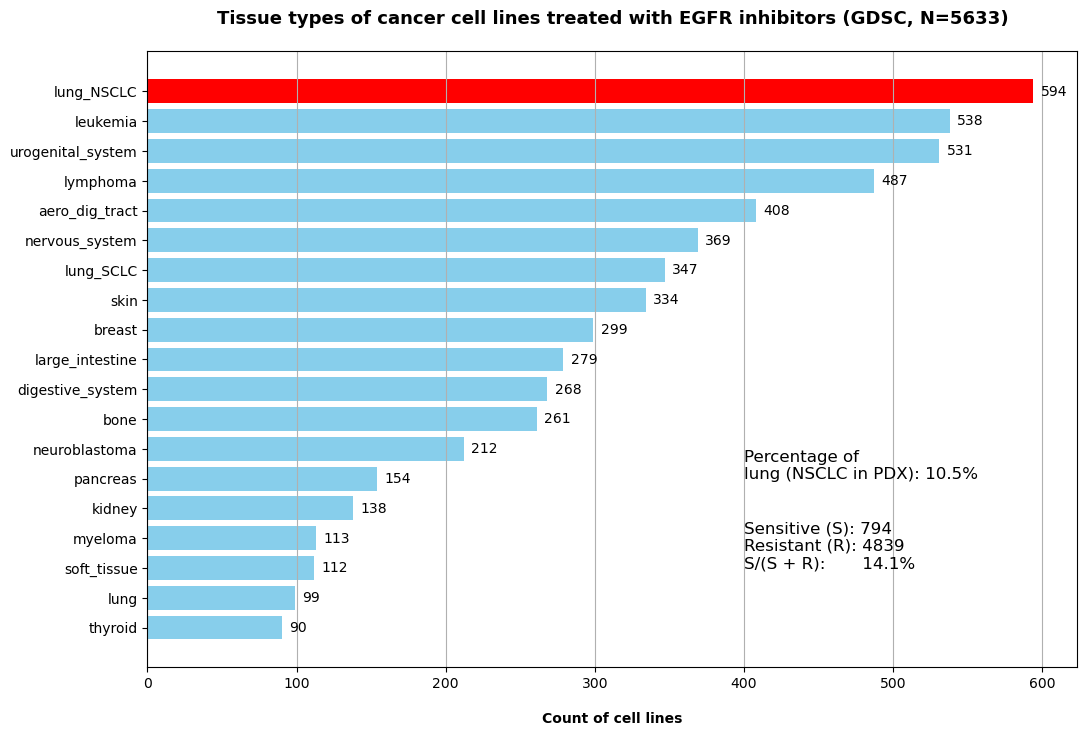

In [40]:
# plot tissue types of cancer cell lines treated with EGFR signaling inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with EGFR inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(400, 13, 
         f'Percentage of \nlung (NSCLC in PDX): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(400, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')


plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with EGFR signaling inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [41]:
# list count of cell lines as to tissues treated with erlotinib

filter = (dat["drug"] == "Erlotinib")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
leukemia             65
lymphoma             59
lung_SCLC            36
nervous_system       27
neuroblastoma        22
bone                 19
lung_NSCLC           18
skin                 18
large_intestine      15
urogenital_system    14
aero_dig_tract       13
digestive_system     12
breast               12
myeloma              11
kidney                8
soft_tissue           7
lung                  2
pancreas              2
thyroid               2
Name: count, dtype: int64

In [42]:
# list count of cell lines as to tissues treated with erlotinib

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Erlotinib")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    36
acute_myeloid_leukaemia      25
B_cell_lymphoma              25
glioma                       25
neuroblastoma                22
Name: count, dtype: int64

In [43]:
# count of NSCLC samples

count_selected_tissues = tissues_drug["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_large cell"].astype(int) + \
                         tissues_drug["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_not specified"].astype(int) + \
                         tissues_drug["lung_NSCLC_carcinoid"].astype(int) 
count_selected_tissues

18

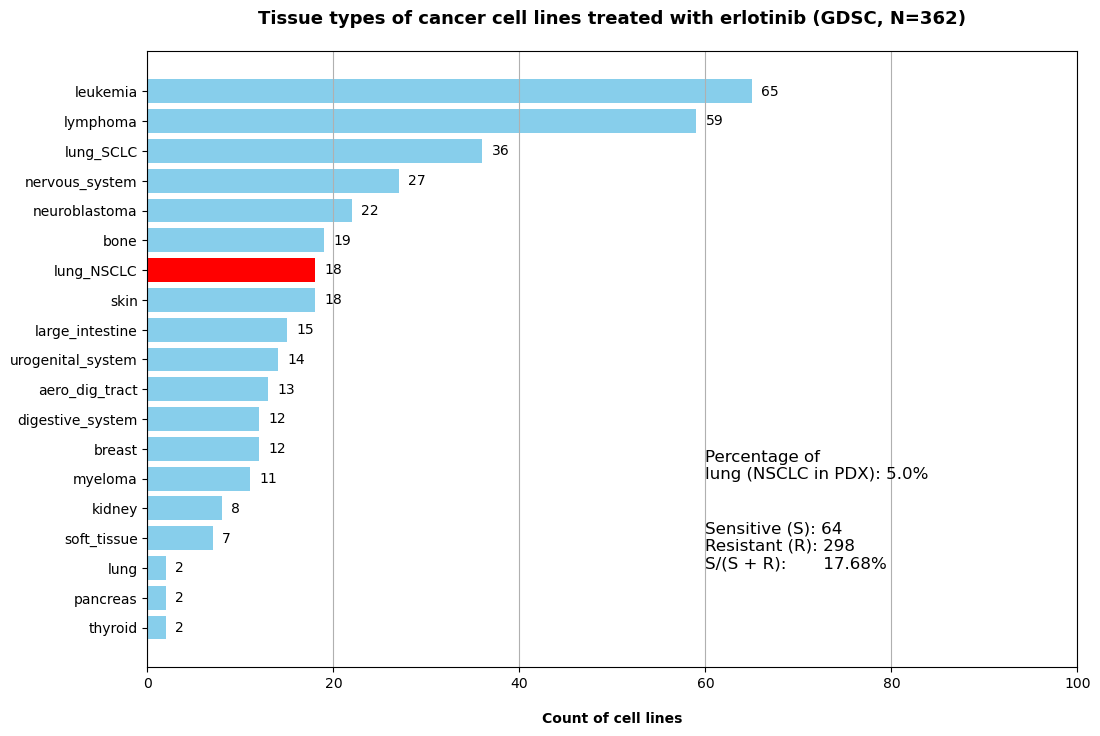

In [44]:
# plot tissue types of cancer cell lines treated with erlotinib

gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with erlotinib (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.xlim(0, 100)
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(60, 13, 
         f'Percentage of \nlung (NSCLC in PDX): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(60, 16, 
         f'Sensitive (S): {dat.loc[dat["drug"] == "Erlotinib", "response"].value_counts()[1]} \nResistant (R): {dat.loc[dat["drug"] == "Erlotinib", "response"].value_counts()[0]} \nS/(S + R):       {round(dat.loc[dat["drug"] == "Erlotinib", "response"].value_counts()[1]/(sum(dat.loc[dat["drug"] == "Erlotinib", "response"].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with erlotinib (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [45]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683667',
       ...
       '910930', '910941', '910941', '924248', '924248', '924248', '906849',
       '906849', '949162', '949162'],
      dtype='object', length=5633)

In [46]:
# filter GDSC expression and mutation datasets (EGFRi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls7 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls8 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls8, ls7]
GDSCMv2 = GDSCMv2.loc[ls8, ls7]
GDSCRv2 = GDSCRv2.loc[ls8, :]

PDXEerlotinib = PDXEerlotinib.loc[:,ls7]
PDXMerlotinib = PDXMerlotinib.loc[:,ls7]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Erlotinib (Expression): {PDXEerlotinib.shape}")
print(f"PDX # of common samples and genes for Erlotinib (Mutation): {PDXMerlotinib.shape}\n")

GDSC # of common samples and genes (Expression): (5633, 873)
GDSC # of common samples and genes (Mutation): (5633, 873)
GDSC # of common samples (Response): 5633

PDX # of common samples and genes for Erlotinib (Expression): (21, 873)
PDX # of common samples and genes for Erlotinib (Mutation): (21, 873)



In [48]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 0]


In [49]:
# change directory to read PDX response dataset (Erlotinib)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [50]:
# read PDX response dataset (Erlotinib)

PDXRerlotinib = pd.read_csv("PDX_response.Erlotinib.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRerlotinib.dropna(inplace=True)
PDXRerlotinib.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRerlotinib["response"] = PDXRerlotinib.loc[:, "response"].apply(lambda x: d[x])
Ytserlotinib = PDXRerlotinib["response"].values    

print(f"There are {Ytserlotinib.shape[0]} samples with response data in the PDX (Erlotinib)\n")
Ytserlotinib

There are 21 samples with response data in the PDX (Erlotinib)



array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [51]:
# read PDX dataset to select cohorts (Erlotinib)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "erlotinib",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-1156,NSCLC
X-1172,NSCLC
X-1189,NSCLC
X-1228,NSCLC
X-1323,NSCLC


In [52]:
# merge PDX cohort table with PDX response dataset (Erlotinib)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRerlotinib,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
NSCLC    21
Name: count, dtype: int64

In [53]:
# filter NSCLC cohort samples (Erlotinib)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1658',
       'X-1683', 'X-1725', 'X-1787', 'X-1823', 'X-1934', 'X-1993', 'X-2017',
       'X-2042', 'X-2088', 'X-2094', 'X-3029', 'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [54]:
# filter responses of NSCLC cohort samples (Erlotinib)

Ytserlotinib_nsclc = PDXRerlotinib.loc[pdx_nsclc_samples,"response"].values
Ytserlotinib_nsclc

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [55]:
# count of sensitive and resistance NSCLC samples (Erlotinib)

PDXRerlotinib.loc[pdx_nsclc_samples,"response"].value_counts()

response
0    18
1     3
Name: count, dtype: int64

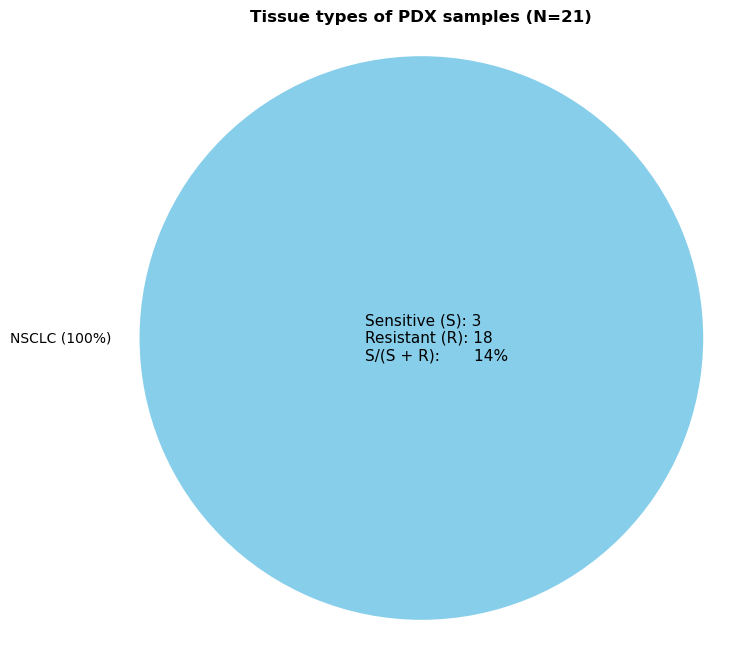

In [56]:
# plot tissue types of PDX samples (Erlotinib)

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue','orange'])
plt.title(f'Tissue types of PDX samples (N={total})', fontweight = "bold")
plt.axis('equal')  

plt.text(-0.2, 0, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts())) * 100, 2).astype(int)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (Erlotinib).png', format='png', bbox_inches='tight')

plt.show()

In [59]:
# define maximum iteration

max_iter = 50

In [60]:
# assign number of neurons and dropout rates found for layers from the saved models

hdm1 = 256
hdm2 = 64
rate1 = 0.8
rate2 = 0.4
rate3 = 0.8

In [61]:
# load pre-trained models and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEerlotinib = scalerGDSC.transform(PDXEerlotinib.values)    
X_testEerlotinib_nsclc = scalerGDSC.transform(PDXEerlotinib.loc[pdx_nsclc_samples,].values) 

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMerlotinib = np.nan_to_num(PDXMerlotinib.values.astype(np.float32))
X_testMerlotinib_nsclc = np.nan_to_num(PDXMerlotinib.loc[pdx_nsclc_samples,].values.astype(np.float32))

TX_testEerlotinib = torch.FloatTensor(X_testEerlotinib)
TX_testEerlotinib_nsclc = torch.FloatTensor(X_testEerlotinib_nsclc)

TX_testMerlotinib = torch.FloatTensor(X_testMerlotinib.astype(np.float32))
TX_testMerlotinib_nsclc = torch.FloatTensor(X_testMerlotinib_nsclc.astype(np.float32))

ty_testEerlotinib = torch.FloatTensor(Ytserlotinib.astype(int))
ty_testEerlotinib_nsclc = torch.FloatTensor(Ytserlotinib_nsclc.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2 

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation.pt")
AutoencoderM = torch.load(models_dir + "Mut_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation.pt")
Clas = torch.load(models_dir + "Class_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (EGFRi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (EGFRi): {round(AUCTaucpr,2)}")

ZETerlotinib = AutoencoderE(TX_testEerlotinib)
ZMTerlotinib = AutoencoderM(TX_testMerlotinib)
ZTTerlotinib = torch.cat((ZETerlotinib, ZMTerlotinib), 1)
ZTTerlotinib = F.normalize(ZTTerlotinib, p=2, dim=0)
PredTerlotinib = Clas(ZTTerlotinib)
AUCTerlotinib = roc_auc_score(Ytserlotinib.astype(int), PredTerlotinib.detach().numpy())
#print(f"PDX - Test AUC (Erlotinib): {round(AUCTerlotinib,2)}")
AUCTerlotinib_aucpr = average_precision_score(Ytserlotinib.astype(int), PredTerlotinib.detach().numpy())
#print(f"PDX - Test AUCPR (Erlotinib): {round(AUCTerlotinib_aucpr,2)}")

ZETerlotinib_nsclc = AutoencoderE(TX_testEerlotinib_nsclc)
ZMTerlotinib_nsclc = AutoencoderM(TX_testMerlotinib_nsclc)
ZTTerlotinib_nsclc = torch.cat((ZETerlotinib_nsclc, ZMTerlotinib_nsclc), 1)
ZTTerlotinib_nsclc = F.normalize(ZTTerlotinib_nsclc, p=2, dim=0)
PredTerlotinib_nsclc = Clas(ZTTerlotinib_nsclc)
AUCTerlotinib_nsclc = roc_auc_score(Ytserlotinib_nsclc.astype(int), PredTerlotinib_nsclc.detach().numpy())
#print(f"PDX - Test AUC (Erlotinib, NSCLC): {round(AUCTerlotinib_nsclc,2)}")
AUCTerlotinib_nsclc_aucpr = average_precision_score(Ytserlotinib_nsclc.astype(int), PredTerlotinib_nsclc.detach().numpy())
#print(f"PDX - Test AUCPR (Erlotinib, NSCLC): {round(AUCTerlotinib_nsclc_aucpr,2)}\n")

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTerlotinib_finetuned = dict()
AUCTerlotinib_nsclc_finetuned = dict()
AUCTerlotinib_aucpr_finetuned = dict()
AUCTerlotinib_nsclc_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(models_dir + f"Finetuned_Models/Exprs_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(models_dir + f"Finetuned_Models/Mut_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(models_dir + f"Finetuned_Models/Class_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZTX = torch.cat((ZEX, ZMX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETerlotinib = AutoencoderE_finetuned(TX_testEerlotinib)
   ZMTerlotinib = AutoencoderM_finetuned(TX_testMerlotinib)
   ZTTerlotinib = torch.cat((ZETerlotinib, ZMTerlotinib), 1)
   ZTTerlotinib = F.normalize(ZTTerlotinib, p=2, dim=0)
   PredTerlotinib = Clas_finetuned(ZTTerlotinib)
   AUCTerlotinib_finetuned[iter] = roc_auc_score(Ytserlotinib.astype(int), PredTerlotinib.detach().numpy())
   AUCTerlotinib_aucpr_finetuned[iter] = average_precision_score(Ytserlotinib.astype(int), PredTerlotinib.detach().numpy())

   ZETerlotinib_nsclc = AutoencoderE_finetuned(TX_testEerlotinib_nsclc)
   ZMTerlotinib_nsclc = AutoencoderM_finetuned(TX_testMerlotinib_nsclc)
   ZTTerlotinib_nsclc = torch.cat((ZETerlotinib_nsclc, ZMTerlotinib_nsclc), 1)
   ZTTerlotinib_nsclc = F.normalize(ZTTerlotinib_nsclc, p=2, dim=0)
   PredTerlotinib_nsclc = Clas_finetuned(ZTTerlotinib_nsclc)
   AUCTerlotinib_nsclc_finetuned[iter] = roc_auc_score(Ytserlotinib_nsclc.astype(int), PredTerlotinib_nsclc.detach().numpy())
   AUCTerlotinib_nsclc_aucpr_finetuned[iter] = average_precision_score(Ytserlotinib_nsclc.astype(int), PredTerlotinib_nsclc.detach().numpy())

max_key = max(AUCTerlotinib_aucpr_finetuned, key=AUCTerlotinib_aucpr_finetuned.get)
max_key_nsclc = max(AUCTerlotinib_nsclc_aucpr_finetuned, key=AUCTerlotinib_nsclc_aucpr_finetuned.get)

print(f"GDSC - Training AUC (EGFRi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (EGFRi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Erlotinib): {round(AUCTerlotinib,2)}")
print(f"PDX - Test AUCPR (Erlotinib): {round(AUCTerlotinib_aucpr,2)}")
print(f"PDX - Test AUC (Erlotinib, NSCLC): {round(AUCTerlotinib_nsclc,2)}")
print(f"PDX - Test AUCPR (Erlotinib, NSCLC): {round(AUCTerlotinib_nsclc_aucpr,2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key],2)}")
print(f"PDX - Test AUC (Erlotinib, Finetuned): {round(AUCTerlotinib_finetuned[max_key],2)}")
print(f"PDX - Test AUCPR (Erlotinib, Finetuned): {round(AUCTerlotinib_aucpr_finetuned[max_key],2)}\n")


print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_nsclc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_nsclc],2)}")
print(f"PDX - Test AUC (Erlotinib, NSCLC, Finetuned): {round(AUCTerlotinib_nsclc_finetuned[max_key_nsclc],2)}")
print(f"PDX - Test AUCPR (Erlotinib, NSCLC, Finetuned): {round(AUCTerlotinib_nsclc_aucpr_finetuned[max_key_nsclc],2)}\n\n")

print("Models for maximum finetuning (Erlotinib)")
print(f"Exprs_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{max_key}.pt")
print(f"CNA_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{max_key}.pt")
print(f"Class_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{max_key}.pt")

print("\nModels for maximum finetuning (Erlotinib, NSCLC)")
print(f"Exprs_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{max_key_nsclc}.pt")
print(f"CNA_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{max_key_nsclc}.pt")
print(f"Class_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_{max_key_nsclc}.pt")

GDSC - Training AUC (EGFRi): 0.85
GDSC - Training AUCPR (EGFRi): 0.47
PDX - Test AUC (Erlotinib): 0.76
PDX - Test AUCPR (Erlotinib): 0.36
PDX - Test AUC (Erlotinib, NSCLC): 0.76
PDX - Test AUCPR (Erlotinib, NSCLC): 0.36

GDSC - Training AUC (EGFRi, Finetuned): 0.79
GDSC - Training AUCPR (EGFRi, Finetuned): 0.32
PDX - Test AUC (Erlotinib, Finetuned): 0.93
PDX - Test AUCPR (Erlotinib, Finetuned): 0.81

GDSC - Training AUC (EGFRi, Finetuned): 0.79
GDSC - Training AUCPR (EGFRi, Finetuned): 0.32
PDX - Test AUC (Erlotinib, NSCLC, Finetuned): 0.93
PDX - Test AUCPR (Erlotinib, NSCLC, Finetuned): 0.81


Models for maximum finetuning (Erlotinib)
Exprs_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_3.pt
CNA_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_3.pt
Class_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_3.pt

Models for maximum finetuning (Erlotinib, NSCLC)
Exprs_Erlotinib_GDSC_PDX_EGFRi_Expression_Mutation_Finetuned_3.pt
CNA_Erlotinib_GDSC_PDX_EGFRi_Expression_Muta

In [72]:
# create a dataframe with the prediction results 

em = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key],2)],
       "AUC (PDX)": [round(AUCTerlotinib,2), round(AUCTerlotinib_finetuned[max_key],2)],
       "AUCPR (PDX)":  [round(AUCTerlotinib_aucpr,2), round(AUCTerlotinib_aucpr_finetuned[max_key],2)],
       "AUC (PDX-NSCLC)":  [round(AUCTerlotinib_nsclc,2), round(AUCTerlotinib_nsclc_finetuned[max_key_nsclc],2)],
       "AUCPR (PDX-NSCLC)": [round(AUCTerlotinib_nsclc_aucpr,2), round(AUCTerlotinib_nsclc_aucpr_finetuned[max_key_nsclc],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}
em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 

em_dataframe.to_csv(save_results_to + "GDSC_PDX_Expression_Mutation_EGFRi_Erlotinib.tsv",
                    sep = "\t",
                    index = False)

em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytserlotinib)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytserlotinib)) + ")",
    "AUC (PDX-NSCLC)": "AUC (PDX-NSCLC, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().astype(int)))) + ")",
    "AUCPR (PDX-NSCLC)": "AUCPR (PDX-NSCLC, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().astype(int)))) + ")",  
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=5633)","AUCPR (GDSC, N=5633)","AUC (PDX, N=21)","AUCPR (PDX, N=21)","AUC (PDX-NSCLC, N=21)","AUCPR (PDX-NSCLC, N=21)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.85,0.47,0.76,0.36,0.76,0.36,5633,873
1,Expr + Mut (Fine-tuned),0.79,0.32,0.93,0.81,0.93,0.81,5633,873


In [76]:
# merge all EM, EC, and EMC dataframes 

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_Expression_Mutation_CNA_EGFRi_Erlotinib.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_Expression_CNA_EGFRi_Erlotinib.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=5633)","AUCPR (GDSC, N=5633)","AUC (PDX, N=21)","AUCPR (PDX, N=21)","AUC (PDX-NSCLC, N=21)","AUCPR (PDX-NSCLC, N=21)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,
Expr + Mut + CNA,0.86,0.5,0.56,0.45,0.56,0.45,5633,872
Expr + Mut + CNA (Fine-tuned),0.86,0.5,0.57,0.46,0.57,0.46,5633,872
Expr + CNA,0.78,0.34,0.81,0.48,0.81,0.48,5633,1019
Expr + CNA (Fine-tuned),0.81,0.43,0.85,0.61,0.85,0.61,5633,1019
Expr + Mut,0.85,0.47,0.76,0.36,0.76,0.36,5633,873
Expr + Mut (Fine-tuned),0.79,0.32,0.93,0.81,0.93,0.81,5633,873


In [77]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=873, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.8, inplace=False)
  )
)

In [78]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=873, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [79]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=320, out_features=1, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): Sigmoid()
  )
)

In [80]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytserlotinib))})",
                               f"AUC (PDX-NSCLC, N={str(len(Ytserlotinib_nsclc))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytserlotinib))})": f"PDX (N={str(len(Ytserlotinib))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRerlotinib["response"].value_counts()[1]) + ", R=" + str(PDXRerlotinib["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRerlotinib["response"].value_counts()[1]/sum(PDXRerlotinib["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-NSCLC, N={str(len(Ytserlotinib_nsclc))})": f"PDX-NSCLC (N={str(len(Ytserlotinib_nsclc))}, p=" + str(PDXEerlotinib.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
auc_dataframe

,"GDSC (N=5633, p=873\nS=794, R=4839, S/N=0.14)","PDX (N=21, p=873\nS=3, R=18, S/N=0.14)","PDX-NSCLC (N=21, p=873\nS=3, R=18, S/N=0.14)"
Data,,,
Expr + Mut + CNA,0.86,0.56,0.56
Expr + Mut + CNA (Fine-tuned),0.86,0.57,0.57
Expr + CNA,0.78,0.81,0.81
Expr + CNA (Fine-tuned),0.81,0.85,0.85
Expr + Mut,0.85,0.76,0.76
Expr + Mut (Fine-tuned),0.79,0.93,0.93


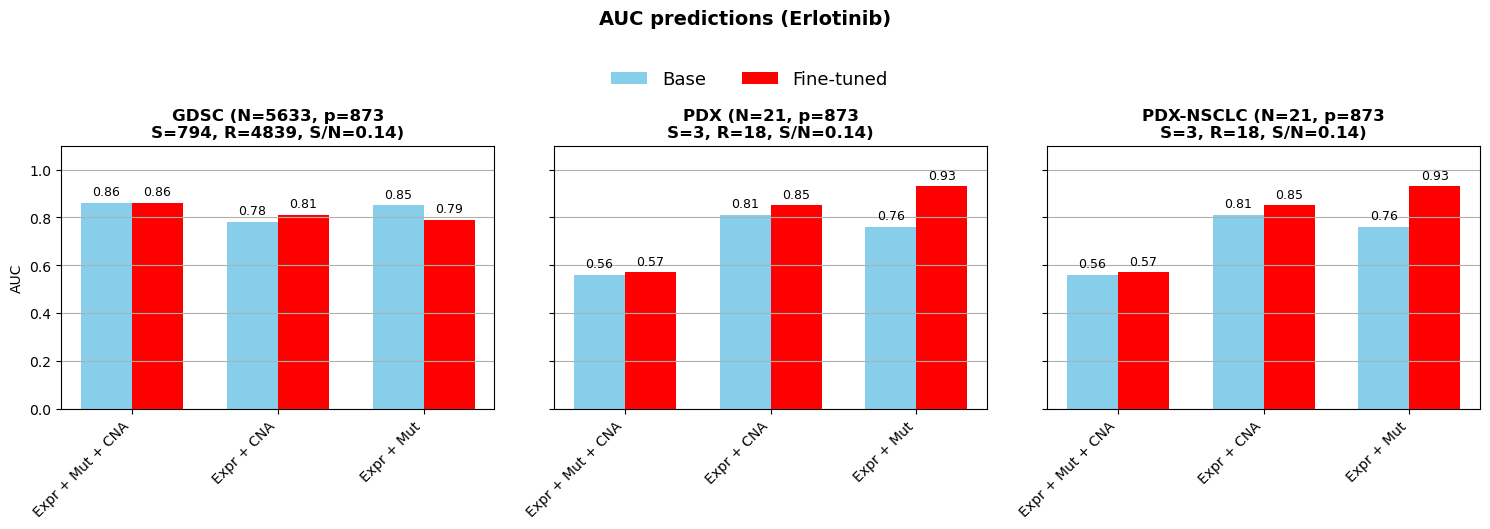

In [82]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Erlotinib)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Erlotinib).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [83]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (PDX, N={str(len(Ytserlotinib))})",
                                 f"AUCPR (PDX-NSCLC, N={str(len(Ytserlotinib_nsclc))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytserlotinib))})": f"PDX (N={str(len(Ytserlotinib))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRerlotinib["response"].value_counts()[1]) + ", R=" + str(PDXRerlotinib["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRerlotinib["response"].value_counts()[1]/sum(PDXRerlotinib["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-NSCLC, N={str(len(Ytserlotinib_nsclc))})": f"PDX-NSCLC (N={str(len(Ytserlotinib_nsclc))}, p=" + str(PDXEerlotinib.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=5633, p=873\nS=794, R=4839, S/N=0.14)","PDX (N=21, p=873\nS=3, R=18, S/N=0.14)","PDX-NSCLC (N=21, p=873\nS=3, R=18, S/N=0.14)"
Data,,,
Expr + Mut + CNA,0.5,0.45,0.45
Expr + Mut + CNA (Fine-tuned),0.5,0.46,0.46
Expr + CNA,0.34,0.48,0.48
Expr + CNA (Fine-tuned),0.43,0.61,0.61
Expr + Mut,0.47,0.36,0.36
Expr + Mut (Fine-tuned),0.32,0.81,0.81


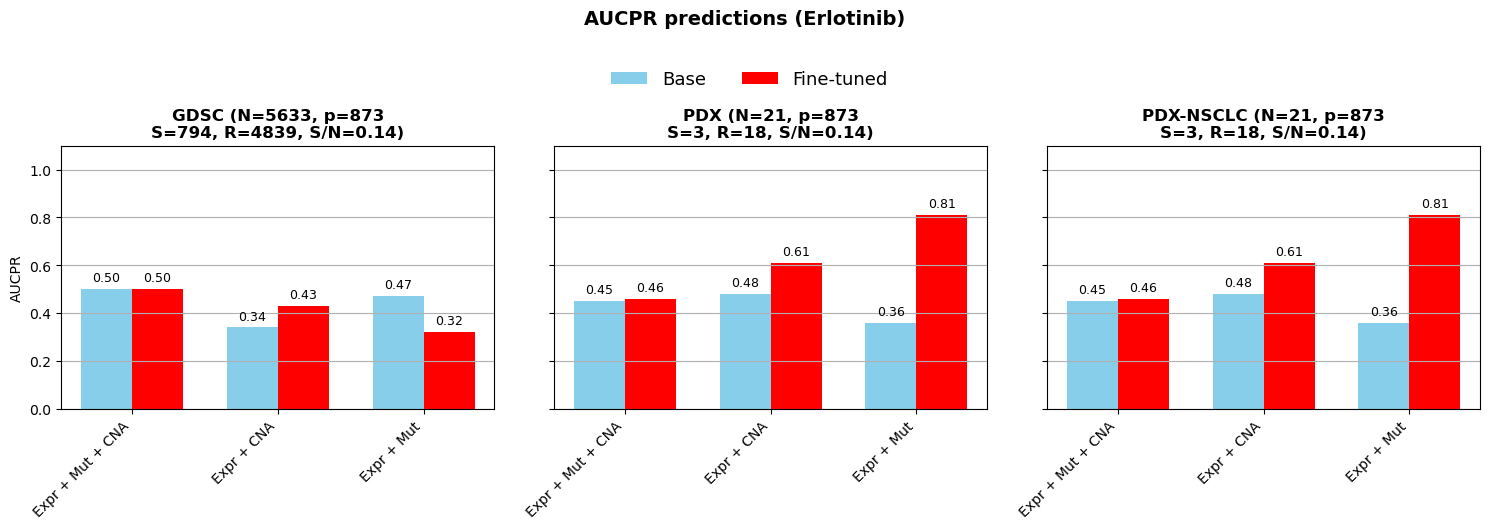

In [84]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Erlotinib)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Erlotinib).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [85]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_EGFRi/Expression_Mutation/Predictions


In [86]:
# save predictions

file = open('GDSC_PDX_DEGs - PDX_EGFRi_Erlotinib Predictions (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (PDX_EGFRi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (PDX_EGFRi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Erlotinib): {round(AUCTerlotinib,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Erlotinib): {round(AUCTerlotinib_aucpr,2)}\n\n")

file.close()